In [1]:
import json
import os
from shapely.geometry import shape, GeometryCollection, Point, Polygon
import pandas as pd
import random
from xml.dom import minidom 

In [9]:
directory = "shapes"
neighbourhoods = {}
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
      with open(f) as file:
        geojson = json.load(file)
        neighbourhoods[filename.split(".")[0]] = Polygon(geojson["coordinates"][0][0])

In [10]:
neighbourhoods["UniaodasfreguesiasdeAldoarFozdoDouroeNevogilde"] = neighbourhoods["Aldoar"].union(neighbourhoods["FozDoDouro"]).union(neighbourhoods["Nevogilde"])
neighbourhoods["UniaodasfreguesiasdeLordelodoOuroeMassarelos"] = neighbourhoods["LordeloDeOuro"].union(neighbourhoods["Massarelos"])
del neighbourhoods["Aldoar"]
del neighbourhoods["FozDoDouro"]
del neighbourhoods["Nevogilde"]
del neighbourhoods["LordeloDeOuro"]
del neighbourhoods["Massarelos"]

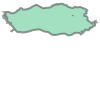

In [13]:
polys = list(neighbourhoods.values())
poly = polys.pop()
while len(polys) > 0:
    poly = poly.union(polys.pop())
poly

In [86]:
movementsDF = pd.read_csv("movimentos_porto_por_freguesia.csv")
movementsDF

,freguesia,genero,ocupacao,destino,valor
0,Paranhos,H,Estudante,Na freguesia onde reside atualmente,1903
1,Paranhos,H,Estudante,"No mesmo município, noutra freguesia",1221
2,Paranhos,M,Empregada,"No mesmo município, noutra freguesia",3802
3,Paranhos,M,Empregada,Na freguesia onde reside atualmente,2224
4,Paranhos,M,Estudante,"No mesmo município, noutra freguesia",1289
...,...,...,...,...,...
139,União das freguesias de Lordelo do Ouro e Mass...,H,Total,"No mesmo município, noutra freguesia",3208
140,União das freguesias de Lordelo do Ouro e Mass...,HM,Empregada,Na freguesia onde reside atualmente,1996
141,União das freguesias de Lordelo do Ouro e Mass...,H,Estudante,Na freguesia onde reside atualmente,986
142,União das freguesias de Lordelo do Ouro e Mass...,HM,Estudante,Na freguesia onde reside atualmente,1955


In [87]:
movementsDF = movementsDF[(movementsDF["genero"] == "HM") & (movementsDF["ocupacao"] == "Total")].reset_index(drop=True)
movementsDF

,freguesia,genero,ocupacao,destino,valor
0,Paranhos,HM,Total,"No mesmo município, noutra freguesia",9362
1,Paranhos,HM,Total,Na freguesia onde reside atualmente,7372
2,"União das freguesias de Cedofeita, Santo Ildef...",HM,Total,Na freguesia onde reside atualmente,6085
3,"União das freguesias de Cedofeita, Santo Ildef...",HM,Total,"No mesmo município, noutra freguesia",7105
4,Paranhos,HM,Total,"No mesmo município, noutra freguesia",172
5,Paranhos,HM,Total,Na freguesia onde reside atualmente,188
6,"União das freguesias de Aldoar, Foz do Douro e...",HM,Total,"No mesmo município, noutra freguesia",6674
7,"União das freguesias de Aldoar, Foz do Douro e...",HM,Total,Na freguesia onde reside atualmente,4261
8,Bonfim,HM,Total,"No mesmo município, noutra freguesia",4946
9,Bonfim,HM,Total,Na freguesia onde reside atualmente,3043


In [88]:
movementsDF["freguesia"] = movementsDF["freguesia"].apply(lambda x: x.replace(" ","").replace("ã","a").replace(",","").replace("é","e").replace("ó","o"))

In [131]:
def generate_random_point_within_polygon(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    while True:
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(random_point):
            return random_point.x, random_point.y

In [133]:
def generate_point(_from, to):
    return [generate_random_point_within_polygon(_from), generate_random_point_within_polygon(to)]

In [160]:
REDUCTION_FACTOR = 0.00014
points = []
for idx, row in movementsDF.iterrows():
    n_agents = int(row["valor"]*REDUCTION_FACTOR)
    for _ in range(n_agents):
        if "noutra" in row["destino"]:
            others = list(neighbourhoods.keys())
            others.remove(row["freguesia"])
            other = random.choice(others)
            points.append(generate_point(neighbourhoods[row["freguesia"]], neighbourhoods[other]))
        else:
            points.append(generate_point(neighbourhoods[row["freguesia"]], neighbourhoods[row["freguesia"]]))

len(points)

3

In [179]:
final = {}
for person, (home, work) in enumerate(points):
    time_home = f"{random.randint(6,12)}:{random.randint(0,60)}:00"
    time_work = f"{random.randint(16,20)}:{random.randint(0,60)}:00"
    act_home = ["h", home[0], home[1], time_home]
    act_work = ["w", work[0], work[1], time_work]
    final[person] = [act_home, act_work, act_home]

final

{0: [['h', -8.609345456615019, 41.173438008634676, '8:54:00'],
  ['w', -8.58499118827316, 41.14715646071553, '17:58:00'],
  ['h', -8.609345456615019, 41.173438008634676, '8:54:00']],
 1: [['h', -8.61677294791843, 41.18147474335053, '6:24:00'],
  ['w', -8.613420091046763, 41.1679637344096, '20:29:00'],
  ['h', -8.61677294791843, 41.18147474335053, '6:24:00']],
 2: [['h', -8.652531292662955, 41.1781035126338, '11:56:00'],
  ['w', -8.675390943653515, 41.16815207285418, '16:56:00'],
  ['h', -8.652531292662955, 41.1781035126338, '11:56:00']]}

In [218]:
#Generate demand XML
root = minidom.Document() 
plansEl = root.createElement("plans")
root.appendChild(plansEl)

for person, plans in final.items():
    personEl = root.createElement("person")
    personEl.setAttribute("id", str(person))
    
    planEl = root.createElement("plan")
    for i, plan in enumerate(plans):
        _type, x, y, time = plan
        actEl = root.createElement("act")
        actEl.setAttribute("type", _type)
        actEl.setAttribute("x", str(x))
        actEl.setAttribute("y", str(y))
        actEl.setAttribute("end_time", time)

        planEl.appendChild(actEl) 
        if i != len(plans)-1:
            legEl = root.createElement("leg")
            legEl.setAttribute("mode", "car")
            planEl.appendChild(legEl)

    personEl.appendChild(planEl)

    plansEl.appendChild(personEl)



xml_str = root.toprettyxml(indent="\t")

with open("plans.xml", "w") as f: 
    f.write(xml_str)

print(xml_str)

<?xml version="1.0" ?>
<plans>
	<person id="0">
		<plan>
			<act type="h" x="-8.609345456615019" y="41.173438008634676" end_time="8:54:00"/>
			<leg mode="car"/>
			<act type="w" x="-8.58499118827316" y="41.14715646071553" end_time="17:58:00"/>
			<leg mode="car"/>
			<act type="h" x="-8.609345456615019" y="41.173438008634676" end_time="8:54:00"/>
		</plan>
	</person>
	<person id="1">
		<plan>
			<act type="h" x="-8.61677294791843" y="41.18147474335053" end_time="6:24:00"/>
			<leg mode="car"/>
			<act type="w" x="-8.613420091046763" y="41.1679637344096" end_time="20:29:00"/>
			<leg mode="car"/>
			<act type="h" x="-8.61677294791843" y="41.18147474335053" end_time="6:24:00"/>
		</plan>
	</person>
	<person id="2">
		<plan>
			<act type="h" x="-8.652531292662955" y="41.1781035126338" end_time="11:56:00"/>
			<leg mode="car"/>
			<act type="w" x="-8.675390943653515" y="41.16815207285418" end_time="16:56:00"/>
			<leg mode="car"/>
			<act type="h" x="-8.652531292662955" y="41.178103512633